# Understanding Probabilistic Programming Through the Monty Hall Problem
![image](../pics/Monty_open_door.svg.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/zolizoli/probprogMonty/blob/main/monty_hall.ipynb)

### Introduction

The [Monty Hall Problem (MHP)](https://en.wikipedia.org/wiki/Monty_Hall_problem) is one of probability theory's most fascinating puzzles - not just for its counter-intuitive solution, but for what it reveals about human reasoning. As Steven Pinker notes, even brilliant mathematicians like Paul Erdős initially rejected the correct solution, and many people persist in their incorrect intuitions even after seeing simulations or playing for money.
This resistance to the correct solution makes the MHP a perfect vehicle for exploring Probabilistic Programming Languages (PPLs). These languages help bridge the gap between our intuitive causal reasoning and formal probabilistic thinking by allowing us to:

+ Explicitly model the causal structure of problems
+ Reason about uncertainty in a principled way
+ Update beliefs based on evidence
+ Separate the model specification from inference

In this notebook, we'll explore both why humans find the MHP so difficult and how PPLs can help us think more clearly about such problems. We'll progress through:

1. Traditional simulation approaches
2. Common reasoning pitfalls
3. Probabilistic programming implementations
4. How PPLs make the solution more transparent

Testing this test to test the test.


### Setup and Imports

In [15]:
import random
import numpy as np
import torch
import pyro
import pyro.distributions as dist
import pandas as pd
import matplotlib.pyplot as plt

# Set device for PyTorch/Pyro
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Part 1: Traditional Simulation Approach
First, let's implement the Monty Hall Problem using traditional Python:

In [3]:
from typing import List, Tuple, Dict, Optional
from dataclasses import dataclass
import random

import numpy as np


@dataclass
class GameResult:
    """
    Stores the result and details of a single Monty Hall game.

    Attributes:
        won: Whether the player won the car
        initial_choice: Door number initially chosen by player (0-2)
        revealed_door: Door number revealed by host (0-2)
        final_choice: Door number of player's final choice (0-2)
        car_location: Door number where car was located (0-2)
    """

    won: bool
    initial_choice: int
    revealed_door: int
    final_choice: int
    car_location: int


class MontyHallGame:
    """
    A class to simulate and analyze the Monty Hall problem.

    This class provides methods to:
    - Play individual games
    - Run multiple simulations
    - Analyze results
    - Track statistics across multiple games

    Attributes:
        n_doors: Number of doors in the game (default is 3)
        results: List of GameResult objects from all played games
    """

    def __init__(self, n_doors: int = 3, seed: Optional[int] = None):
        """
        Initialize the Monty Hall game simulator.

        Args:
            n_doors: Number of doors in the game
            seed: Random seed for reproducibility
        """
        self.n_doors = n_doors
        self.results: List[GameResult] = []

        if seed is not None:
            random.seed(seed)

    def create_doors(self) -> List[int]:
        """
        Creates and shuffles the initial door configuration.

        Returns:
            List[int]: A shuffled list where:
                0 represents a goat
                1 represents the car
        """
        doors = [0] * (self.n_doors - 1) + [1]  # One car, rest goats
        random.shuffle(doors)
        return doors

    def get_possible_reveals(self, doors: List[int], initial_choice: int) -> List[int]:
        """
        Determines which doors the host can reveal.

        Args:
            doors: List of door contents (0=goat, 1=car)
            initial_choice: Door number chosen by contestant

        Returns:
            List[int]: List of door numbers that the host can reveal
        """
        return [i for i in range(self.n_doors) if i != initial_choice and doors[i] == 0]

    def get_final_choice(
        self, initial_choice: int, revealed_door: int, switch: bool
    ) -> int:
        """
        Determines player's final door choice based on strategy.

        Args:
            initial_choice: Door number first chosen by player
            revealed_door: Door number revealed by host
            switch: Whether player switches from initial choice

        Returns:
            int: Door number of final choice
        """
        if not switch:
            return initial_choice

        # If switching, choose the door that's neither initial nor revealed
        return next(
            i for i in range(self.n_doors) if i != initial_choice and i != revealed_door
        )

    def play_game(self, switch: bool = True) -> GameResult:
        """
        Play a single game of Monty Hall.

        Args:
            switch: Whether the player switches their door choice

        Returns:
            GameResult: Object containing game outcome and choices
        """
        # Setup game
        doors = self.create_doors()
        initial_choice = random.randint(0, self.n_doors - 1)

        # Host reveals a door
        possible_reveals = self.get_possible_reveals(doors, initial_choice)
        revealed_door = random.choice(possible_reveals)

        # Player makes final choice
        final_choice = self.get_final_choice(initial_choice, revealed_door, switch)

        # Determine outcome
        won = doors[final_choice] == 1
        car_location = doors.index(1)

        # Create and store result
        result = GameResult(
            won=won,
            initial_choice=initial_choice,
            revealed_door=revealed_door,
            final_choice=final_choice,
            car_location=car_location,
        )
        self.results.append(result)

        return result

    def simulate(
        self, num_trials: int = 10000, switch: bool = True
    ) -> Tuple[float, List[GameResult]]:
        """
        Run multiple simulations of the Monty Hall game.

        Args:
            num_trials: Number of games to simulate
            switch: Whether the player switches their door choice

        Returns:
            Tuple containing:
                - Win rate as a float between 0 and 1
                - List of GameResult objects for all trials
        """
        results = [self.play_game(switch) for _ in range(num_trials)]
        win_rate = sum(result.won for result in results) / num_trials
        return win_rate, results

    def analyze_results(self, results: Optional[List[GameResult]] = None) -> Dict:
        """
        Analyze results of Monty Hall games.

        Args:
            results: List of GameResult objects to analyze
                    If None, analyzes all stored results

        Returns:
            Dict containing statistics:
                - win_rate: Overall win rate
                - initial_choices: Distribution of initial door choices
                - revealed_doors: Distribution of doors revealed by host
                - car_locations: Distribution of car locations
        """
        if results is None:
            results = self.results

        n_games = len(results)
        if n_games == 0:
            return {}

        # Calculate distributions
        stats = {
            "win_rate": sum(r.won for r in results) / n_games,
            "initial_choices": [
                sum(r.initial_choice == i for r in results) / n_games
                for i in range(self.n_doors)
            ],
            "revealed_doors": [
                sum(r.revealed_door == i for r in results) / n_games
                for i in range(self.n_doors)
            ],
            "car_locations": [
                sum(r.car_location == i for r in results) / n_games
                for i in range(self.n_doors)
            ],
        }

        return stats

    def clear_results(self) -> None:
        """Clear all stored game results."""
        self.results = []

In [4]:
game = MontyHallGame(seed=42)

# Run simulations for both strategies
stay_rate, stay_results = game.simulate(num_trials=10000, switch=False)
game.clear_results()  # Clear results between runs

switch_rate, switch_results = game.simulate(num_trials=10000, switch=True)

# Print results
print(f"Stay win rate: {stay_rate:.1%}")
print(f"Switch win rate: {switch_rate:.1%}")

# Analyze detailed results
stay_stats = game.analyze_results(stay_results)
switch_stats = game.analyze_results(switch_results)

print("\nDetailed Statistics when staying:")
for key, value in stay_stats.items():
    print(f"{key}: {value}")


Stay win rate: 33.1%
Switch win rate: 66.5%

Detailed Statistics when staying:
win_rate: 0.3314
initial_choices: [0.3385, 0.3363, 0.3252]
revealed_doors: [0.3308, 0.3318, 0.3374]
car_locations: [0.3294, 0.3399, 0.3307]


## Part 2: Probabilistic Programming Implementation

Now let's implement the same problem using Pyro, highlighting the key differences in approach:

In [10]:
from typing import Dict, List
import torch
import pyro
from dataclasses import dataclass


@dataclass
class PPLGameResult:
    """
    Stores the result of a probabilistic Monty Hall game simulation.

    Attributes:
        stay_wins: Whether staying with initial choice would win
        switch_wins: Whether switching doors would win
        prize_door: Door number containing the prize
        initial_door: Door number initially chosen
        host_door: Door number revealed by host
        final_door_if_switch: Door number if switching
        probabilities: Dictionary of computed probabilities
    """

    stay_wins: bool
    switch_wins: bool
    prize_door: int
    initial_door: int
    host_door: int
    final_door_if_switch: int
    probabilities: Dict[str, float]


class MontyHallPPL:
    """
    Probabilistic Programming implementation of the Monty Hall Problem.
    """

    def __init__(self, n_doors: int = 3, device: str = "cpu"):
        """
        Initialize the probabilistic Monty Hall game.

        Args:
            n_doors: Number of doors in the game
            device: Computation device ('cpu' or 'cuda')
        """
        self.n_doors = n_doors
        self.device = torch.device(device)
        self.prior_probs = torch.ones(n_doors, device=self.device) / n_doors

    def calculate_host_probabilities(
        self, prize_door: int, contestant_door: int
    ) -> torch.Tensor:
        """
        Calculate probability distribution for host's door choice.

        The host must:
        1. Never reveal the prize door
        2. Never reveal the contestant's chosen door
        3. Choose randomly among remaining valid doors

        Args:
            prize_door: Door containing the prize
            contestant_door: Door chosen by contestant

        Returns:
            torch.Tensor: Probability distribution over host's choices
        """
        if prize_door == contestant_door:
            # Host can reveal any door except the contestant's (prize) door
            probs = torch.ones(self.n_doors, device=self.device) / (self.n_doors - 1)
            probs[contestant_door] = 0.0
        else:
            # Host must avoid both prize and contestant doors
            probs = torch.ones(self.n_doors, device=self.device)
            probs[contestant_door] = 0.0
            probs[prize_door] = 0.0
            # Normalize remaining probabilities
            probs = probs / probs.sum()

        return probs

    def simulate_game(self) -> PPLGameResult:
        """
        Simulate one complete game using probabilistic programming.

        This method explicitly models:
        1. Random prize placement
        2. Contestant's random choice
        3. Host's constrained decision
        4. Outcome probabilities

        Returns:
            PPLGameResult: Complete game outcome and probabilities
        """
        # Sample prize location (uniform prior)
        prize_door = pyro.sample("prize_door", dist.Categorical(self.prior_probs))

        # Sample contestant's choice (uniform prior)
        contestant_door = pyro.sample(
            "contestant_door", dist.Categorical(self.prior_probs)
        )

        # Calculate host's choice probabilities
        host_probs = self.calculate_host_probabilities(
            int(prize_door.cpu()), int(contestant_door.cpu())
        )

        # Sample host's reveal
        host_door = pyro.sample("host_door", dist.Categorical(host_probs))

        # Convert to CPU for set operations
        contestant_door_cpu = int(contestant_door.cpu())
        host_door_cpu = int(host_door.cpu())
        prize_door_cpu = int(prize_door.cpu())

        # Calculate switching door (the unselected, unrevealed door)
        doors = set(range(self.n_doors))
        switch_door = doors - {contestant_door_cpu, host_door_cpu}
        switch_door = next(iter(switch_door))

        # Calculate outcomes
        stay_wins = (contestant_door == prize_door).cpu().item()
        switch_wins = switch_door == prize_door_cpu

        # Store probabilities for analysis
        probs = {
            "stay_win_prob": float(stay_wins),
            "switch_win_prob": float(switch_wins),
            "host_reveal_probs": host_probs.cpu().numpy().tolist(),
        }

        return PPLGameResult(
            stay_wins=stay_wins,
            switch_wins=switch_wins,
            prize_door=prize_door_cpu,
            initial_door=contestant_door_cpu,
            host_door=host_door_cpu,
            final_door_if_switch=switch_door,
            probabilities=probs,
        )

    def run_inference(self, num_samples: int = 1000) -> List[PPLGameResult]:
        """
        Run multiple game simulations and perform inference.

        Args:
            num_samples: Number of games to simulate

        Returns:
            List[PPLGameResult]: Results of all simulations
        """
        results = []
        for _ in range(num_samples):
            pyro.clear_param_store()
            results.append(self.simulate_game())
        return results

    def analyze_results(self, results: List[PPLGameResult]) -> Dict[str, float]:
        """
        Analyze results of multiple probabilistic simulations.

        Args:
            results: List of game results to analyze

        Returns:
            Dict containing:
                - stay_win_rate: Empirical probability of winning by staying
                - switch_win_rate: Empirical probability of winning by switching
                - host_reveal_distribution: Distribution of host's choices
        """
        n_games = len(results)
        if n_games == 0:
            return {}

        analysis = {
            "stay_win_rate": sum(r.stay_wins for r in results) / n_games,
            "switch_win_rate": sum(r.switch_wins for r in results) / n_games,
            "host_reveal_distribution": [
                sum(r.host_door == i for r in results) / n_games
                for i in range(self.n_doors)
            ],
        }

        return analysis

In [14]:
# Create PPL game instance
game = MontyHallPPL(device='cpu')

# Run simulations
results = game.run_inference(num_samples=10000)

# Analyze results
analysis = game.analyze_results(results)

print("Probabilistic Simulation Results:")
print(f"Stay win rate: {analysis['stay_win_rate']:.3f}")
print(f"Switch win rate: {analysis['switch_win_rate']:.3f}")
print(f"Host reveal distribution: {analysis['host_reveal_distribution']}")

# Look at a single game in detail
sample_game = results[0]
print("\nSample Game Details:")
print(f"Prize Door: {sample_game.prize_door}")
print(f"Initial Choice: {sample_game.initial_door}")
print(f"Host Revealed: {sample_game.host_door}")
print(f"Switch Door: {sample_game.final_door_if_switch}")
print(f"Probabilities: {sample_game.probabilities}")

Probabilistic Simulation Results:
Stay win rate: 0.333
Switch win rate: 0.667
Host reveal distribution: [0.3401, 0.328, 0.3319]

Sample Game Details:
Prize Door: 0
Initial Choice: 2
Host Revealed: 1
Switch Door: 0
Probabilities: {'stay_win_prob': 0.0, 'switch_win_prob': 1.0, 'host_reveal_probs': [0.0, 1.0, 0.0]}


### From Simulation to Probabilistic Programming
After implementing a traditional simulation of the Monty Hall problem, let's examine why we might want to use a probabilistic programming approach instead. While both approaches can demonstrate the paradox, probabilistic programming languages (PPLs) offer several key advantages:
1. Explicit Probability Modeling
PPLs make probabilities and their relationships explicit in the code. Compare these approaches:
```python
# Traditional approach - probabilities are implicit
if random.random() < 0.5:  # Hidden probability
    choose_door_1()

# PPL approach - probabilities are explicit
door_choice = pyro.sample("choice", dist.Categorical(probs))
```
This explicit representation makes it easier to understand and reason about the probabilistic structure of our model.
2. Inference Capabilities
While traditional simulation only allows forward simulation (generating outcomes), PPLs enable:

+ Learning from observed data
+ Updating beliefs based on evidence
+ Inferring unobserved variables

For example, we can condition our model on observed behavior:
```python
# Conditioning on observations (only possible with PPL)
conditioned_model = pyro.condition(
    model,
    data={"player_choice": observed_choices}
)
```
3. Flexibility for Extensions
The probabilistic programming approach makes it easier to modify and extend the model. We can add:

+ Noise in player decisions
+ Learning effects over multiple games
+ Prior knowledge about strategy
+ Missing or partial data

Here's a simple example of adding decision noise:
```python
def monty_hall_with_noise(noise_level: float = 0.1):
    # Base probability of switching
    switch_prob = 0.5

    # Add noise to decision
    actual_prob = pyro.sample(
        "noisy_prob",
        dist.Normal(switch_prob, noise_level)
    )

    return pyro.sample("decision", dist.Bernoulli(actual_prob))
```
4. Declarative Nature
PPL code focuses on describing WHAT the model is, rather than HOW to simulate it. This makes the code more:

+ Readable: The model structure is clear
+ Maintainable: Changes to the model are localized
+ Reusable: Components can be easily combined

For example:
```python
# Traditional: Focus on HOW to simulate
def simulate_traditional():
    doors = [0, 0, 1]
    random.shuffle(doors)
    choice = random.randint(0, 2)
    # ... implementation details

# PPL: Focus on WHAT the model is
def model_ppl():
    prize_location = pyro.sample("prize", dist.Categorical(probs))
    player_choice = pyro.sample("choice", dist.Categorical(probs))
    # ... model structure
```
These advantages become particularly important as we move towards modeling learning and reasoning in Parts 3 and 4, where we'll need to infer cognitive parameters from observed behavior.

## Part 3: Learning Models
In this section, we explore how agents might learn the optimal strategy for the Monty Hall problem through experience. We'll implement and compare different learning approaches, progressing from simple to more sophisticated models.
### Why Study Learning?
The Monty Hall problem is particularly interesting from a learning perspective because:

+ The optimal strategy is counter-intuitive
+ Even after being told the correct answer, many people remain skeptical
+ The problem demonstrates how experience can overcome incorrect intuitions

### Learning Models
We implement two types of learning agents:
#### 1. Simple Reinforcement Learner

+ Maintains a single value estimate for the "switch" action
+ Updates this estimate based on observed outcomes
+ Uses a learning rate to control how quickly it adapts
+ Represents a simple, model-free approach to learning
```python
# Example of simple RL update rule
new_value = old_value + learning_rate * (reward - old_value)
```
#### 2. Bayesian Learner
+ Maintains explicit probability distributions over outcomes
+ Updates beliefs using Bayes' rule
+ Has no learning rate parameter
+ Represents a more sophisticated, model-based approach
```python
# Example of Bayesian update
posterior_alpha = prior_alpha + successes
posterior_beta = prior_beta + failures
```
Let's see the code!

In [17]:
from dataclasses import dataclass
from typing import List, Dict, Union


@dataclass
class LearningResult:
    """
    Stores the results of a learning agent's game.

    Attributes:
        game_number: Which game in the sequence
        switch_probability: Agent's probability of switching before decision
        switched: Whether agent actually switched
        won: Whether agent won
        current_belief: Agent's updated belief after the game
    """

    game_number: int
    switch_probability: float
    switched: bool
    won: bool
    current_belief: float


class SimpleReinforcementLearner:
    """
    A basic reinforcement learning agent that learns through direct experience.
    Uses a simple value update rule: V = V + lr * (R - V)
    """

    def __init__(self, learning_rate: float = 0.1):
        self.lr = learning_rate
        self.switch_value = 0.5  # Initial belief about switching
        self.history: List[LearningResult] = []
        self.game_count = 0

    def decide(self) -> bool:
        """Make a decision whether to switch based on current value estimate"""
        return np.random.random() < self.switch_value

    def update(self, switched: bool, won: bool) -> None:
        """Update value estimate based on game outcome"""
        self.game_count += 1
        reward = 1.0 if won else 0.0

        # Store current state before update
        old_value = self.switch_value

        # Update based on outcome
        if switched:
            self.switch_value += self.lr * (reward - self.switch_value)
        else:
            # If stayed, update based on opposite outcome
            self.switch_value += self.lr * ((1 - reward) - self.switch_value)

        # Record result
        self.history.append(
            LearningResult(
                game_number=self.game_count,
                switch_probability=old_value,
                switched=switched,
                won=won,
                current_belief=self.switch_value,
            )
        )


class BayesianLearner:
    """
    A Bayesian learning agent that maintains explicit probability distributions
    over the value of switching vs staying.
    """

    def __init__(self, prior_alpha: float = 1.0, prior_beta: float = 1.0):
        self.switch_alpha = prior_alpha
        self.switch_beta = prior_beta
        self.history: List[LearningResult] = []
        self.game_count = 0

    def decide(self) -> bool:
        """Make decision by sampling from current belief distribution"""
        switch_prob = self.switch_alpha / (self.switch_alpha + self.switch_beta)
        return np.random.random() < switch_prob

    def update(self, switched: bool, won: bool) -> None:
        """Update beliefs using Bayesian inference"""
        self.game_count += 1

        # Store current state before update
        old_prob = self.switch_alpha / (self.switch_alpha + self.switch_beta)

        # Update beliefs
        if switched:
            self.switch_alpha += won
            self.switch_beta += 1 - won
        else:
            # If stayed, opposite outcome would have occurred from switching
            self.switch_alpha += 1 - won
            self.switch_beta += won

        # Record result
        new_prob = self.switch_alpha / (self.switch_alpha + self.switch_beta)
        self.history.append(
            LearningResult(
                game_number=self.game_count,
                switch_probability=old_prob,
                switched=switched,
                won=won,
                current_belief=new_prob,
            )
        )


def run_learning_experiment(
    learner: Union[SimpleReinforcementLearner, BayesianLearner], n_games: int = 100
) -> List[LearningResult]:
    """Run a sequence of games with a learning agent"""
    for _ in range(n_games):
        # Setup game
        doors = [0, 0, 1]
        np.random.shuffle(doors)
        initial_choice = np.random.randint(3)

        # Host reveals a goat
        possible_reveals = [
            i for i in range(3) if i != initial_choice and doors[i] == 0
        ]
        revealed_door = np.random.choice(possible_reveals)

        # Learner decides
        should_switch = learner.decide()

        # Get final choice and outcome
        if should_switch:
            final_choice = next(
                i for i in range(3) if i != initial_choice and i != revealed_door
            )
        else:
            final_choice = initial_choice

        # Update learner
        won = doors[final_choice] == 1
        learner.update(should_switch, won)

    return learner.history


def plot_learning_curves(
    histories: Dict[str, List[LearningResult]], title: str = "Learning Curves"
) -> None:
    """Visualize learning curves for different agents"""
    plt.figure(figsize=(10, 6))

    for name, history in histories.items():
        games = [r.game_number for r in history]
        beliefs = [r.current_belief for r in history]
        plt.plot(games, beliefs, label=name)

    plt.axhline(y=2 / 3, color="r", linestyle="--", label="Optimal Strategy")
    plt.xlabel("Games Played")
    plt.ylabel("Probability of Switching")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Example usage and comparison
def compare_learners(n_games: int = 100):
    """Compare different types of learners"""
    # Initialize learners
    rl_slow = SimpleReinforcementLearner(learning_rate=0.05)
    rl_fast = SimpleReinforcementLearner(learning_rate=0.2)
    bayes = BayesianLearner()

    # Run experiments
    histories = {
        "RL (slow)": run_learning_experiment(rl_slow, n_games),
        "RL (fast)": run_learning_experiment(rl_fast, n_games),
        "Bayesian": run_learning_experiment(bayes, n_games),
    }

    # Plot results
    plot_learning_curves(histories, "Comparison of Learning Strategies")

    # Print final beliefs
    print("\nFinal Beliefs about Switching:")
    for name, history in histories.items():
        print(f"{name}: {history[-1].current_belief:.3f}")

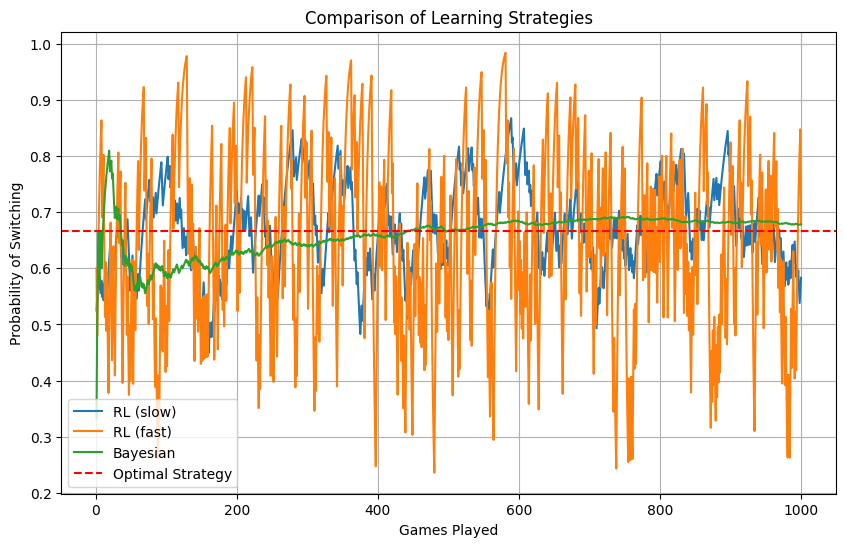


Final Beliefs about Switching:
RL (slow): 0.583
RL (fast): 0.678
Bayesian: 0.679


In [21]:
compare_learners(n_games=1000)

#### Experimental Results
We can observe several interesting patterns:
+ All learners eventually approach the optimal strategy (⅔ probability of switching)
+ Learning rates affect both speed of convergence and stability
+ Bayesian learners show more consistent behavior
+ Initial beliefs can significantly impact learning trajectories


# Part 4: Backward Simulation and Cognitive Modeling
In this section, we use probabilistic programming to infer how players reason about the Monty Hall problem. Instead of simulating forward from rules to behavior, we work backward from observed behavior to understand players' decision-making processes.

## Cognitive Parameters
We model three key aspects of player cognition:

+ Host Awareness (0-1) - How much does the player consider the host's knowledge?
    - Low: Treats host's door choice as random
    - High: Understands host must reveal a goat


+ Switch Bias (0-1) - Player's baseline tendency to switch doors
    - Low: Prefers to stick with initial choice
    - High: Naturally inclined to switch


+ Rationality (0-1) - How consistently does the player follow their strategy?
    - Low: More random decisions
    - High: Consistent application of strategy



## Player Types
We model three prototypical players:

+ Naive Players
    - Low host awareness
    - Low switch bias
    - Medium-high rationality
    - Typically maintain initial choice


+ Intuitive Players
    - Medium host awareness
    - Medium switch bias
    - Medium rationality
    - Sometimes switch based on intuition


+ Analytical Players
    - High host awareness
    - High switch bias
    - High rationality
    - Usually switch after analysis



## Model Structure
The cognitive model:
1. Places prior distributions on cognitive parameters
2. Models how these parameters influence decisions
3. Conditions on observed behavior
4. Infers likely parameter values

In [22]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
from dataclasses import dataclass
from typing import List, Dict, Optional


@dataclass
class PlayerData:
    """
    Represents observed player behavior in Monty Hall games.

    Attributes:
        switch_decisions: List of whether player switched (1) or stayed (0)
        wins: List of whether player won each game
        n_games: Total number of games played
    """

    switch_decisions: List[int]
    wins: List[int]
    n_games: int


@dataclass
class CognitiveParameters:
    """
    Represents inferred cognitive parameters of a player.

    Attributes:
        host_awareness: How much player considers host's knowledge (0-1)
        switch_bias: Player's inherent tendency to switch (0-1)
        rationality: How consistently player follows their strategy (0-1)
    """

    host_awareness: float
    switch_bias: float
    rationality: float


class MontyHallCognitiveModel:
    """
    Probabilistic model for inferring player's decision-making process.
    """

    def __init__(self, device: str = "cpu"):
        self.device = torch.device(device)

    def model(self, data: Optional[PlayerData] = None) -> None:
        """
        Probabilistic model of player's decision-making process.
        Models three key cognitive parameters:
        1. Host awareness: Understanding of host's strategic behavior
        2. Switch bias: Prior tendency to switch doors
        3. Rationality: Consistency in decision making
        """
        # Prior distributions over cognitive parameters
        host_awareness = pyro.sample(
            "host_awareness", dist.Beta(torch.tensor(2.0), torch.tensor(2.0))
        )

        switch_bias = pyro.sample(
            "switch_bias", dist.Beta(torch.tensor(1.0), torch.tensor(1.0))
        )

        rationality = pyro.sample(
            "rationality", dist.Beta(torch.tensor(5.0), torch.tensor(1.0))
        )

        # If we have data, condition on it
        if data is not None:
            for i in range(data.n_games):
                # Compute switching probability
                switch_prob = switch_bias + host_awareness * 0.33
                switch_prob = torch.clamp(switch_prob, 0.0, 1.0)

                # Add rationality (higher rationality = more consistent decisions)
                switch_prob = switch_prob * rationality + 0.5 * (1 - rationality)

                # Observe decision
                pyro.sample(
                    f"switch_{i}",
                    dist.Bernoulli(switch_prob),
                    obs=torch.tensor(float(data.switch_decisions[i])),
                )

    def guide(self, data: Optional[PlayerData] = None) -> None:
        """Variational guide for inference"""
        # Variational parameters for host_awareness
        host_a = pyro.param(
            "host_a", torch.tensor(2.0), constraint=dist.constraints.positive
        )
        host_b = pyro.param(
            "host_b", torch.tensor(2.0), constraint=dist.constraints.positive
        )

        # Variational parameters for switch_bias
        switch_a = pyro.param(
            "switch_a", torch.tensor(1.0), constraint=dist.constraints.positive
        )
        switch_b = pyro.param(
            "switch_b", torch.tensor(1.0), constraint=dist.constraints.positive
        )

        # Variational parameters for rationality
        rat_a = pyro.param(
            "rat_a", torch.tensor(5.0), constraint=dist.constraints.positive
        )
        rat_b = pyro.param(
            "rat_b", torch.tensor(1.0), constraint=dist.constraints.positive
        )

        # Sample from variational distributions
        pyro.sample("host_awareness", dist.Beta(host_a, host_b))
        pyro.sample("switch_bias", dist.Beta(switch_a, switch_b))
        pyro.sample("rationality", dist.Beta(rat_a, rat_b))


def generate_synthetic_data(player_type: str, n_games: int = 100) -> PlayerData:
    """
    Generate synthetic player data for different cognitive types.

    Args:
        player_type: One of ['naive', 'intuitive', 'analytical']
        n_games: Number of games to simulate
    """
    if player_type == "naive":
        # Rarely switches, doesn't understand host's role
        host_aware = 0.1
        switch_bias = 0.2
        rationality = 0.8
    elif player_type == "intuitive":
        # Sometimes switches, partially understands host
        host_aware = 0.5
        switch_bias = 0.4
        rationality = 0.7
    else:  # analytical
        # Often switches, understands host's role
        host_aware = 0.9
        switch_bias = 0.6
        rationality = 0.9

    decisions = []
    wins = []

    for _ in range(n_games):
        # Compute switch probability
        switch_prob = switch_bias + host_aware * 0.33
        switch_prob = np.clip(switch_prob, 0, 1)

        # Add rationality
        switch_prob = switch_prob * rationality + 0.5 * (1 - rationality)

        # Make decision
        switched = int(np.random.random() < switch_prob)
        decisions.append(switched)

        # Determine if won (2/3 chance if switched, 1/3 if stayed)
        won = int(np.random.random() < (2 / 3 if switched else 1 / 3))
        wins.append(won)

    return PlayerData(switch_decisions=decisions, wins=wins, n_games=n_games)


def infer_cognitive_parameters(
    data: PlayerData, num_steps: int = 1000
) -> CognitiveParameters:
    """
    Perform variational inference to estimate cognitive parameters.
    """
    # Initialize model and inference algorithm
    pyro.clear_param_store()
    model = MontyHallCognitiveModel()

    # Setup inference
    optimizer = Adam({"lr": 0.01})
    svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

    # Run inference
    for _ in range(num_steps):
        svi.step(data)

    # Get parameters
    host_a = pyro.param("host_a").item()
    host_b = pyro.param("host_b").item()
    switch_a = pyro.param("switch_a").item()
    switch_b = pyro.param("switch_b").item()
    rat_a = pyro.param("rat_a").item()
    rat_b = pyro.param("rat_b").item()

    # Compute means
    return CognitiveParameters(
        host_awareness=host_a / (host_a + host_b),
        switch_bias=switch_a / (switch_a + switch_b),
        rationality=rat_a / (rat_a + rat_b),
    )


def analyze_player(player_data: PlayerData) -> Dict:
    """
    Analyze player behavior and infer cognitive parameters.
    """
    # Basic statistics
    switch_rate = sum(player_data.switch_decisions) / player_data.n_games
    win_rate = sum(player_data.wins) / player_data.n_games

    # Infer cognitive parameters
    params = infer_cognitive_parameters(player_data)

    return {
        "behavioral_stats": {"switch_rate": switch_rate, "win_rate": win_rate},
        "cognitive_params": params,
    }

In [24]:
# Generate synthetic data for different player types
player_types = ["naive", "intuitive", "analytical"]
results = []

for ptype in player_types:
    data = generate_synthetic_data(ptype, n_games=100)
    analysis = analyze_player(data)

    # Create row for DataFrame
    results.append(
        {
            "Player Type": ptype,
            "Switch Rate": f"{analysis['behavioral_stats']['switch_rate']:.2f}",
            "Win Rate": f"{analysis['behavioral_stats']['win_rate']:.2f}",
            "Host Awareness": f"{analysis['cognitive_params'].host_awareness:.2f}",
            "Switch Bias": f"{analysis['cognitive_params'].switch_bias:.2f}",
            "Rationality": f"{analysis['cognitive_params'].rationality:.2f}",
        }
    )

# Create and display DataFrame
columns = [
    "Player Type",
    "Switch Rate",
    "Win Rate",
    "Host Awareness",
    "Switch Bias",
    "Rationality",
]
results_df = pd.DataFrame(results)[columns]

In [25]:
results_df


,Player Type,Switch Rate,Win Rate,Host Awareness,Switch Bias,Rationality
0,naive,0.32,0.44,0.44,0.10,0.64
1,intuitive,0.61,0.50,0.49,0.59,0.45
2,analytical,0.85,0.64,0.63,0.90,0.72


## Sources
+ [Why You Should Always Switch: The Monty Hall Problem (Finally) Explained](https://behavioralscientist.org/steven-pinker-rationality-why-you-should-always-switch-the-monty-hall-problem-finally-explained/)
+ [Why Humans Fail in Solving the Monty Hall Dilemma: A Systematic Review](https://pmc.ncbi.nlm.nih.gov/articles/PMC6194549/)